In [58]:
import os
import numpy as np
import matplotlib.pyplot as plt

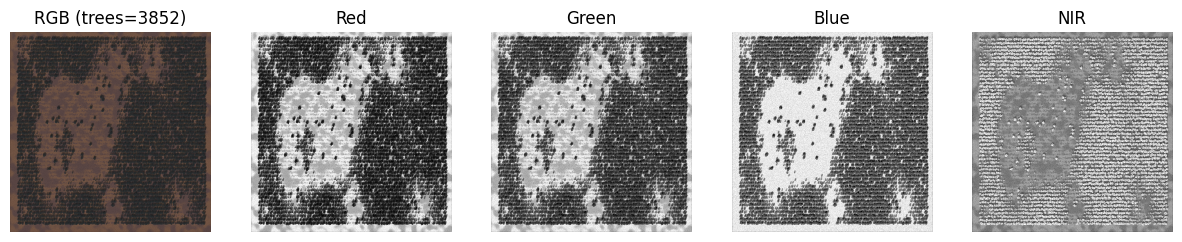

In [59]:
index = 0
dir = "outputs"
norm_factor = 1600

output = np.load(os.path.join(dir, "output.npy"))
count = np.load(os.path.join(dir, "count.npy"))

image = (output[index]/1600).transpose(1, 2, 0)

fig, axs = plt.subplots(1, 5, figsize=(15, 10))
axs[0].imshow(image[:,:,:3])
axs[1].imshow(image[:,:,0], cmap="gray")
axs[2].imshow(image[:,:,1], cmap="gray")
axs[3].imshow(image[:,:,2], cmap="gray")
axs[4].imshow(image[:,:,3], cmap="gray")

axs[0].set_title(f"RGB (trees={count[index].item()})")
axs[1].set_title("Red")
axs[2].set_title("Green")
axs[3].set_title("Blue")
axs[4].set_title("NIR")

for i in range(5):
    axs[i].axis("off")

fig.show()

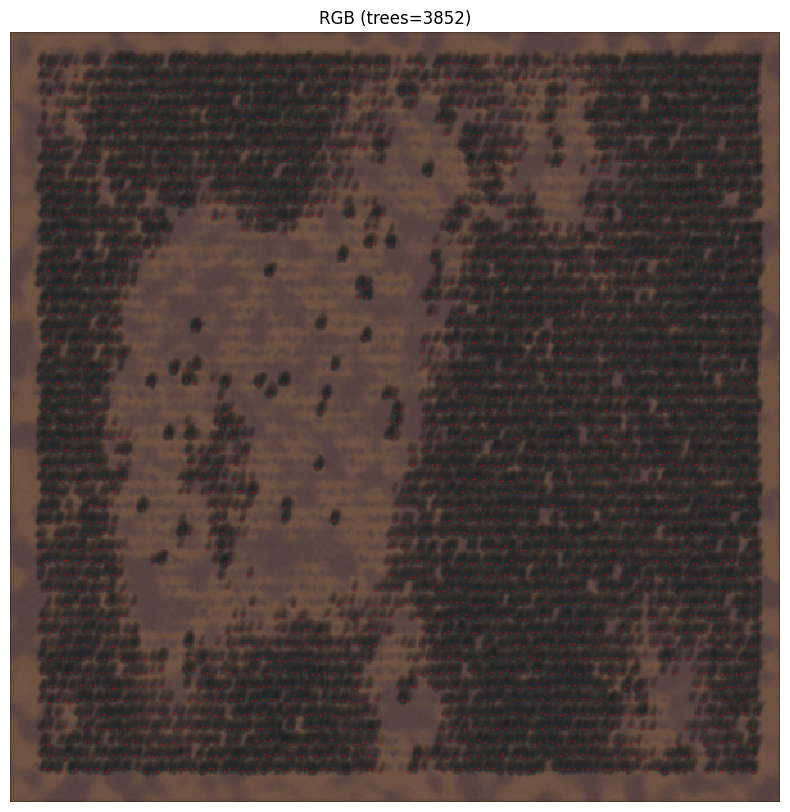

In [60]:
index = 0
dir = "outputs"
norm_factor = 1600

output = np.load(os.path.join(dir, "output.npy"))
coordinates = np.load(os.path.join(dir, "coordinates.npz"))
count = np.load(os.path.join(dir, "count.npy"))


image = (output[index]/1600).transpose(1, 2, 0)
coords = coordinates[f"coords{index}"]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(image[:,:,:3])
ax.scatter(coords[:, 0], coords[:, 1], marker='.', c="red", s=1, alpha=0.5)

ax.set_title(f"RGB (trees={count[index].item()})")

ax.axis("off")

fig.show()

(16, 4, 600, 600)
(4, 4, 1200, 1200)
(36, 4, 256, 256)


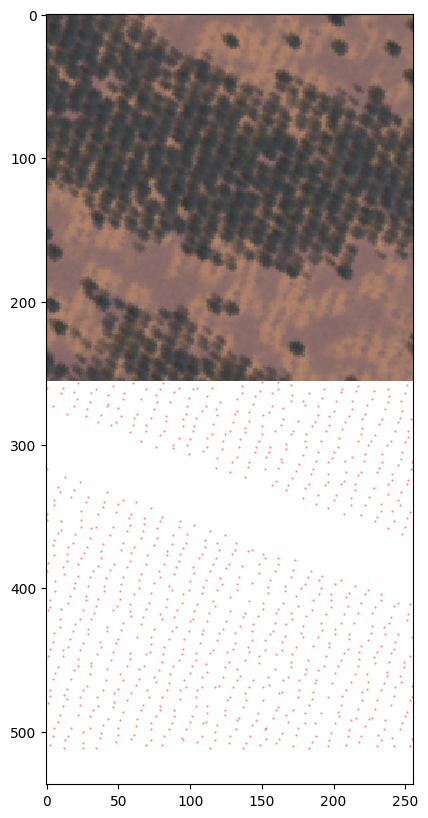

In [ ]:
import torch
import math
from torchvision.transforms import v2
import matplotlib.patches as patches

index = 1
angle = 70
# angle_rest = angle % 90
# angle_rad = math.radians(angle)
# angle_rest_rad = math.radians(45-angle_rest)
# image = torch.tensor(output[0])
# image = v2.functional.rotate(image, angle)
# radius = image.shape[-1]//2
# crop_factor = (math.sqrt(2) - 1/math.cos(angle2_rad))*math.cos(math.pi/4)
# crop = math.ceil(crop_factor * radius)
# image = v2.functional.crop(image, crop, crop, image.shape[1]-crop*2, image.shape[2]-crop*2)

def coords_npz_to_list(npz_coordinates):
    coords = []
    for i in range(len(npz_coordinates)):
        coords.append(npz_coordinates[f"coords{i}"].astype(int))
    return coords

def _tile_nxn(images, tile_n):
    """
    images: (tile_n**2 * B, C, H, W)
    tile_n: int, e.g., 2, 3, 4, ...
    Returns: (B, C, tile_n * H, tile_n * W)
    """
    total, C, H, W = images.shape
    B = total // (tile_n ** 2)

    # Step 1: reshape into (B, tile_n, tile_n, C, H, W)
    images = images.reshape(B, tile_n, tile_n, C, H, W)

    # Step 2: transpose to move tiling into spatial dimensions
    images = images.transpose(0, 3, 1, 4, 2, 5)  # (B, C, tile_n, H, tile_n, W)

    # Step 3: merge tiling into height and width
    images = images.reshape(B, C, tile_n * H, tile_n * W)

    return images

def glue_together(image, coords, tile_number):
    print(image.shape)
    newimage = _tile_nxn(image, tile_number)
    newcoords = []
    for k in range(len(coords)//(tile_number**2)):
        newcoor_list = []
        for i in range(tile_number):
            for j in range(tile_number):
                coor = coords[k*tile_number**2+i*tile_number+j]
                newcoor_list.append(coor + np.array([j*image.shape[-2], i*image.shape[-1]]))
        newcoords.append(np.concatenate(newcoor_list, axis=0))
    return newimage, newcoords

def rotate_n_crop(image, angle_deg):
    image = torch.tensor(image)
    image = v2.functional.rotate(image, angle_deg)
    angle_rad = math.radians(angle_deg)
    radius = image.shape[-1]//2
    angle_rad_rest = angle_rad % (math.pi/2)
    crop_factor = (math.sqrt(2) - 1/math.cos(math.pi/4-angle_rad_rest))*math.cos(math.pi/4)
    crop = math.ceil(crop_factor * radius)
    image = v2.functional.crop(image, crop, crop, image.shape[-2]-crop*2, image.shape[-1]-crop*2)
    return np.array(image), crop

def rotate_coords(coords, origin, angle_deg):
    newcoords = []
    for coor in coords:
        newcoor = np.zeros_like(coor)
        angle_rad = math.radians(angle_deg)
        dx, dy = coor[:, 0] - origin[0], coor[:, 1] - origin[1]
        newcoor[:, 0] = origin[0] + dx * math.cos(-angle_rad) - dy * math.sin(-angle_rad)
        newcoor[:, 1] = origin[1] + dx * math.sin(-angle_rad) + dy * math.cos(-angle_rad)
        newcoords.append(newcoor)
    return newcoords

def crop_coordinates(coords, crop_left, crop_top, crop_width, crop_height):
    newcoords = []
    for coor in coords:
        newcoor = np.zeros_like(coor)
        newcoor[:, 0] = coor[:, 0] - crop_left
        newcoor[:, 1] = coor[:, 1] - crop_top
        newcoor = newcoor[(newcoor[:, 0] >= 0) & (newcoor[:, 0] < crop_width) & (newcoor[:, 1] >= 0) & (newcoor[:, 1] < crop_height)]
        newcoords.append(newcoor)
    return newcoords

def split_n_crop(image, coords, tile_size):
    image = torch.tensor(image)
    N_tiles = image.shape[-2] // tile_size
    M_tiles = image.shape[-1] // tile_size
    image = v2.functional.crop(image, 0, 0, tile_size*N_tiles, tile_size*M_tiles)
    newimage = image.reshape(-1, 4, N_tiles, tile_size, M_tiles, tile_size).permute(0, 2, 4, 1, 3, 5).reshape(-1, 4, tile_size, tile_size)
    newcoords = []
    for coor in coords:
        for i in range(N_tiles):
            for j in range(M_tiles):
                crop_left, crop_top = i*tile_size, j*tile_size
                newcoor = np.zeros_like(coor)
                newcoor[:, 0] = coor[:, 0] - crop_left
                newcoor[:, 1] = coor[:, 1] - crop_top
                newcoor = coor[(newcoor[:, 0] >= 0) & (newcoor[:, 0] < tile_size) & (newcoor[:, 1] >= 0) & (newcoor[:, 1] < tile_size)]
                newcoords.append(newcoor)
    newimage = np.array(newimage)
    return newimage, newcoords

def coords_to_treecount(coords):
    treecount = []
    for coor in coords:
        treecount.append(coor.shape[0])
    return np.array(treecount)

coords = coords_npz_to_list(coordinates)
newimage, newcoords = glue_together(output, coords, 2)
print(newimage.shape)
newcoords = rotate_coords(newcoords, (newimage.shape[-2]//2, newimage.shape[-1]//2), angle)
newimage, crop = rotate_n_crop(newimage, angle)
newcoords = crop_coordinates(newcoords, crop, crop, newimage.shape[-2], newimage.shape[-1])
newimage, newcoords = split_n_crop(newimage, newcoords, 256)
print(newimage.shape)
treecount = coords_to_treecount(newcoords)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(newimage[index].transpose(1, 2, 0)[:,:,:3]/2**10)
# rect = patches.Rectangle((crop, crop), image.shape[2]-2*crop, image.shape[2]-2*crop, linewidth=1, edgecolor='r', facecolor='none')
# ax.add_patch(rect)
ax.scatter(newcoords[index][:, 0], newcoords[index][:, 1], marker='.', c="red", s=1, alpha=0.5)
fig.show()